The idea is to segment data into smaller more manageable inputs and outputs. We want to train a model able to predict the haplotypes after training on all the short inputs, and then merge them to reconstruct the whole chromosome.

# Design model

## CNN + LSTM + double-length

### Define and train the model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM, TimeDistributed, Bidirectional
from keras.layers import Conv1D, Conv2D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils, plot_model
import pickle

/Users/jeje/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
n = 16    # founders
p = 1015  # nb of SNPs
G = 20    # nb of generations
N = 100   # number recombining individuals in a generation after sampling
I = 100   # nb of itérations

**Import simulations** : genotypes and haplotypes, F = founders, d = descendants.

In [4]:
with open("Recombinations_haplotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    haplo = pickle.load(handler)
    F_haplo = np.array(haplo[:n])
    d_haplo = np.array(haplo[n:])
display(F_haplo.shape,d_haplo.shape)
        
with open("Recombinations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    geno = pickle.load(handler)
    F_geno = np.array(geno[:n])
    d_geno = np.array(geno[n:])
    
with open("Linkage_p{}.pkl".format(p),"rb") as handler:
    linkage = pickle.load(handler)

display(F_geno.shape,d_geno.shape, linkage.shape)

(16, 1015)

(10000, 1015)

(16, 1015)

(10000, 1015)

(1015,)

In [5]:
xtrain = d_geno[:3*I*N//4]
ytrain = d_haplo[:3*I*N//4]
xtest = d_geno[3*I*N//4:]
ytest = d_haplo[3*I*N//4:]
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((7500, 1015), (7500, 1015), (2500, 1015), (2500, 1015))

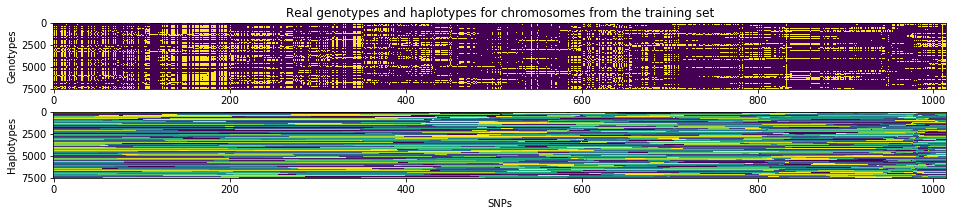

In [6]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,3))
ax1.imshow(xtrain, aspect = 0.01)
ax1.set(ylabel = "Genotypes", title = "Real genotypes and haplotypes for chromosomes from the training set")
ax2.imshow(ytrain, aspect = 0.01)
ax2.set(ylabel = "Haplotypes", xlabel = "SNPs")
plt.show()

**Input genotypes** : creating an "image" with the descendant x17 alterning with the 16 founders and the linkage.

In [7]:
def chromosome_alternate_inputs_5 (array, F_geno, linkage, n):
    A = np.zeros((array.shape[0],array.shape[1],3*n+1))
    for k in range(len(array)) :
        individual = array[k]
        a = individual[:, np.newaxis]
        for l in range(len(F_geno)) :
            a=np.concatenate([a,F_geno[l:l+1].T, linkage[:, np.newaxis], individual[:, np.newaxis]], axis = 1)
        A[k]=a
    return A

**Output haplotypes** in 2 SNPs-long segments.

In [8]:
def chromosome_segments_output (array):
    B = np.zeros((len(array),len(array[0])//2,16))
    for k in range(len(array)) :
        individual = array[k]
        B[k] = np.array([np_utils.to_categorical(segment[1]-1,16) for segment in np.reshape(individual[:len(individual)//2*2],(-1,2))])
    return B

In [9]:
Xtrain = chromosome_alternate_inputs_5(xtrain, F_geno, linkage, n)
display(Xtrain.shape)
Ytrain = chromosome_segments_output(ytrain)
display(Ytrain.shape)
Xtest = chromosome_alternate_inputs_5(xtest, F_geno, linkage, n)
display(Xtest.shape)
Ytest = chromosome_segments_output(ytest)
display(Ytest.shape)

(7500, 1015, 49)

(7500, 507, 16)

(2500, 1015, 49)

(2500, 507, 16)

**Segment** all data in smaller more manageable inputs and outputs.

Given G recombination events (= generations because we assumed 1 recombination by generation), we can calculate the probability of having no recombination between 2 points with evenly distributed recombinations loci :

$$P = \Big(\frac{\text{total length - length}}{\text{total length}}\Big)^\text{number of generations} = \Big(\frac{p - L}{p}\Big)^G$$

So we can get the minimum required length L to have most of the information ($99\%$) :

$$P>1\% \implies \Big(\frac{p - L}{p}\Big)^G > 0.01 \implies p - L > p \times \sqrt[G]{0.01} \implies L < p(1 - \sqrt[G]{0.01})$$

In [10]:
def length_segment (p, G, risk) :
    return int(p*(1-risk**(1/G)))

risk = 0.05
length_segment(p, G, risk)

141

In [11]:
def random_segmentation_1 (A, B, p, G, risk) :
    l = length_segment(p, G, risk)
    assert p-2*l >= 0, p-2*l
    assert int(p/2) <= B.shape[1], (int(p/2), B.shape[1])
    X = np.zeros((A.shape[0]*math.ceil(p/l),2*l,A.shape[2]))
    Y = np.zeros((B.shape[0]*math.ceil(p/l),l,B.shape[2]))
    for i in range(p):
        for j in range(math.ceil(p/l)):
            r = np.random.randint(0,p-2*l)
            X[i*math.ceil(p/l)+j] = A[i,r:r+2*l]
            Y[i*math.ceil(p/l)+j] = B[i,int(r/2):int(r/2)+l]
    return X,Y

In [12]:
Xtrain_seg, Ytrain_seg = random_segmentation_1 (Xtrain, Ytrain, p, G, risk)
display(Xtrain_seg.shape, Ytrain_seg.shape)

Xtest_seg, Ytest_seg = random_segmentation_1 (Xtest, Ytest, p, G, risk)
display(Xtest_seg.shape, Ytest_seg.shape)

(60000, 282, 49)

(60000, 141, 16)

(20000, 282, 49)

(20000, 141, 16)

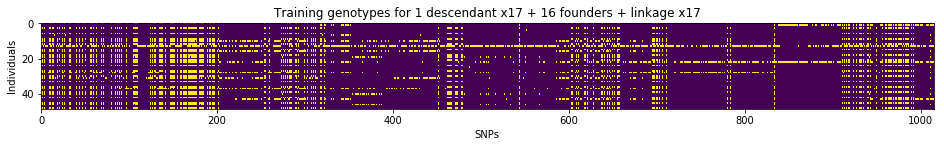

In [13]:
im, ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(Xtrain[0].T, aspect = 2)
ax.set(xlabel = "SNPs", ylabel = "Individuals", title = "Training genotypes for 1 descendant x17 + 16 founders + linkage x17")
plt.show()

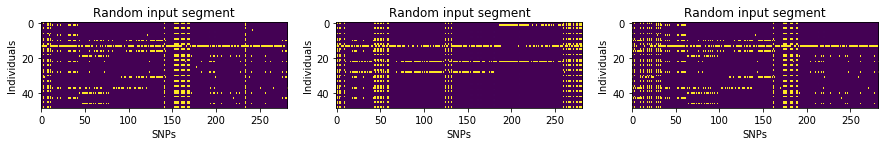

In [15]:
im, ax = plt.subplots(1,3,figsize=(15,3))
for i in range(3):
    ax[i].imshow(Xtrain_seg[i].T, aspect = 2)
    ax[i].set(xlabel = "SNPs", ylabel = "Individuals", title = "Random input segment")
plt.show()

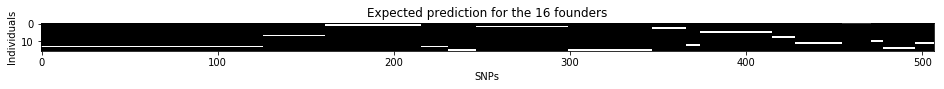

In [19]:
im, ax = plt.subplots(1,1,figsize=(16,6))
ax.imshow(Ytrain[0].T, aspect = 1, cmap = "Greys_r")
ax.set(xlabel = "SNPs", ylabel = "Individuals", title = "Expected prediction for the 16 founders")
plt.show()

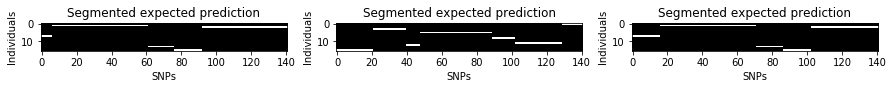

In [18]:
im, ax = plt.subplots(1,3,figsize=(15,2))
for i in range(3):
    ax[i].imshow(Ytrain_seg[i].T, aspect = 1, cmap = "Greys_r")
    ax[i].set(xlabel = "SNPs", ylabel = "Individuals", title = "Segmented expected prediction")
plt.show()

**Define LSTM** :

In [83]:
K.clear_session()

model_1 = Sequential()
model_1.add(Conv1D(49, kernel_size=2,
                 activation='relu',
                 input_shape=Xtest_seg.shape[1:], padding = 'same'))
model_1.add(Conv1D(30, kernel_size=2, activation='relu', padding='same'))
model_1.add(AveragePooling1D(pool_size=2,strides=2))
model_1.add(Dropout(0.25))
model_1.add(Conv1D(16, kernel_size=2, activation='relu', padding='same'))
model_1.add(Dropout(0.25))
model_1.add(TimeDistributed(Dense(16, activation='relu')))
model_1.add(Dropout(0.5))
model_1.add(TimeDistributed(Dense(16, activation='relu')))
model_1.add(Dropout(0.5))
model_1.add(Bidirectional(LSTM(8, return_sequences=True)))
model_1.add(TimeDistributed(Dense(Ytest_seg.shape[2], activation='softmax')))
model_1.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
filepath="Scalable1_model_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
print(model_1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 282, 49)           4851      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 282, 30)           2970      
_________________________________________________________________
average_pooling1d_1 (Average (None, 141, 30)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 141, 30)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 141, 16)           976       
_________________________________________________________________
dropout_2 (Dropout)          (None, 141, 16)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 141, 16)           272       
__________

In [84]:
plot_model(model_1, show_shapes=True, to_file='Models/Scalable1_model.png')

**Train LSTM** :

In [87]:
epochs=1
history_1 = model_1.fit(Xtrain_seg, Ytrain_seg,
          epochs=epochs,
          callbacks=callbacks_list,
          verbose=1,
          validation_data=(Xtest_seg, Ytest_seg))

Train on 60000 samples, validate on 20000 samples
Epoch 1/1
60000/60000 [==============================] - 1517s 25ms/step - loss: 0.3184 - acc: 0.0254 - val_loss: 0.9564 - val_acc: 0.0478

Epoch 00001: val_acc improved from -inf to 0.04775, saving model to Scalable1_model_weights-improvement-01-0.05.hdf5


$\to$ Reached **% accuracy after  epochs**.

In [13]:
with open('Scalable1_model_history.pkl', 'wb') as handler:
        pickle.dump(history_1.history, handler)

### Load Check-Pointed model and make predictions : new simulations

In [90]:
with open("Recombinations_haplotypes_test_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    haplo = pickle.load(handler)
    F_haplo_test = np.array(haplo[:n])
    d_haplo_test = np.array(haplo[n:])
display(F_haplo_test.shape,d_haplo_test.shape)
        
with open("Recombinations_genotypes_test_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    geno = pickle.load(handler)
    F_geno_test = np.array(geno[:n])
    d_geno_test = np.array(geno[n:])
    
with open("Linkage_p{}.pkl".format(p),"rb") as handler:
    linkage = pickle.load(handler)

display(F_geno_test.shape,d_geno_test.shape, linkage.shape)

(16, 1015)

(10000, 1015)

(16, 1015)

(10000, 1015)

(1015,)

In [91]:
K.clear_session()

model_1 = Sequential()
model_1.add(Conv1D(49, kernel_size=2,
                 activation='relu',
                 input_shape=Xtest_seg.shape[1:], padding = 'same'))
model_1.add(Conv1D(30, kernel_size=2, activation='relu', padding='same'))
model_1.add(AveragePooling1D(pool_size=2,strides=2))
model_1.add(Dropout(0.25))
model_1.add(Conv1D(16, kernel_size=2, activation='relu', padding='same'))
model_1.add(Dropout(0.25))
model_1.add(TimeDistributed(Dense(16, activation='relu')))
model_1.add(Dropout(0.5))
model_1.add(TimeDistributed(Dense(16, activation='relu')))
model_1.add(Dropout(0.5))
model_1.add(Bidirectional(LSTM(8, return_sequences=True)))
model_1.add(TimeDistributed(Dense(Ytest_seg.shape[2], activation='softmax')))
model_1.load_weights("Models/Scalable1_model_weights/Scalable1_model_weights-improvement-01-0.05.hdf5")       # load weights
model_1.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
print(model_1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 282, 49)           4851      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 282, 30)           2970      
_________________________________________________________________
average_pooling1d_1 (Average (None, 141, 30)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 141, 30)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 141, 16)           976       
_________________________________________________________________
dropout_2 (Dropout)          (None, 141, 16)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 141, 16)           272       
__________

In [93]:
Xdata = chromosome_alternate_inputs_5(d_geno_test, F_geno_test, linkage, n)
display(Xdata.shape)
Ydata = chromosome_segments_output(d_haplo_test)
display(Ydata.shape)
Xdata_seg, Ydata_seg = random_segmentation_1 (Xdata, Ydata, p, G, risk)
display(Xtest_seg.shape, Ytest_seg.shape)
Ypred_seg = model_1.predict(Xdata_seg)
display(Ypred_seg.shape)

(10000, 1015, 49)

(10000, 507, 16)

(20000, 282, 49)

(20000, 141, 16)

(80000, 141, 16)

In [94]:
model_1.evaluate(Xdata_seg, Ydata_seg)

80000/80000 [==============================] - 282s 4ms/step


[0.23074189252853394, 0.016796897181868553]

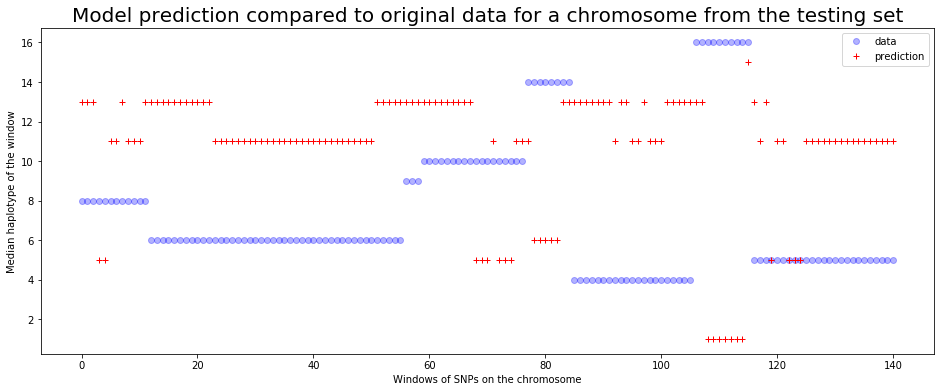

In [96]:
im, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot([np.argmax(data)+1 for data in Ydata_seg[0]], 'bo', label="data",alpha=0.3)
ax.plot([np.argmax(pred)+1 for pred in Ypred_seg[0]], 'r+', label="prediction")
ax.legend()
plt.xlabel("Windows of SNPs on the chromosome")
plt.ylabel("Median haplotype of the window")
plt.title("Model prediction compared to original data for a chromosome from the testing set",fontsize=20)
plt.show()

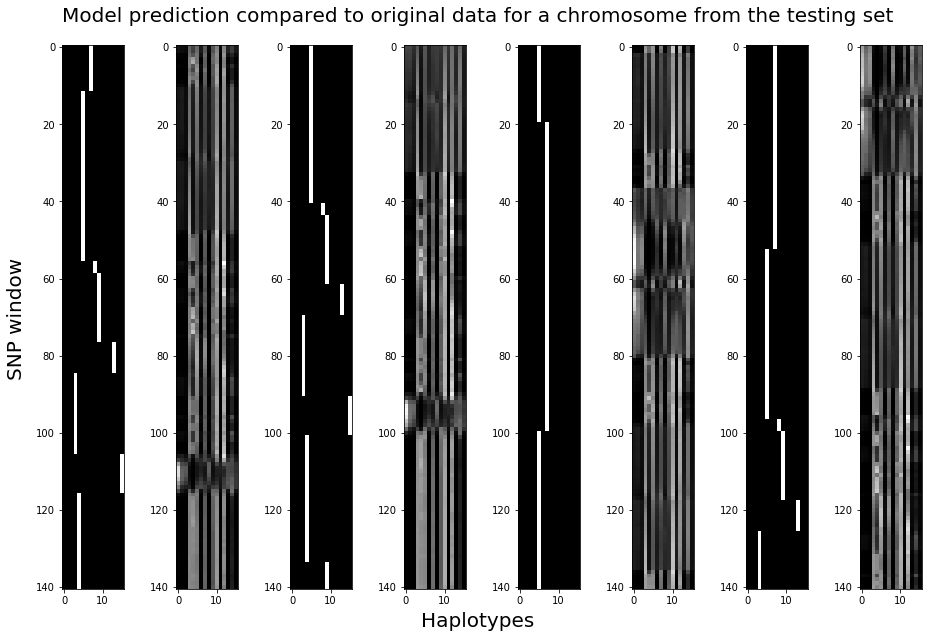

In [100]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(1,8,figsize=(16,10))
ax1.imshow(Ydata_seg[0],cmap="Greys_r", aspect = 1)
ax2.imshow(Ypred_seg[0],cmap="Greys_r", aspect = 1)
ax3.imshow(Ydata_seg[1],cmap="Greys_r", aspect = 1)
ax4.imshow(Ypred_seg[1],cmap="Greys_r", aspect = 1)
ax5.imshow(Ydata_seg[2],cmap="Greys_r", aspect = 1)
ax6.imshow(Ypred_seg[2],cmap="Greys_r", aspect = 1)
ax7.imshow(Ydata_seg[3],cmap="Greys_r", aspect = 1)
ax8.imshow(Ypred_seg[3],cmap="Greys_r", aspect = 1)
fig.text(0.5, 0.08, 'Haplotypes', ha='center', va='center',fontsize=20)
fig.text(0.1, 0.5, 'SNP window', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5, 0.92, 'Model prediction compared to original data for a chromosome from the testing set', ha='center', va='center',fontsize=20)
plt.show()

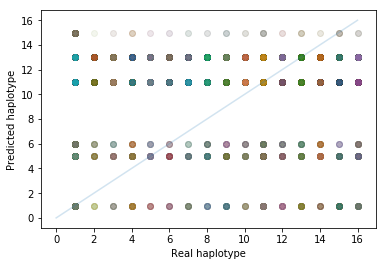

In [102]:
plt.plot([0,16],[0,16],alpha=0.2)
for i in range(0, Ydata_seg.shape[0], 50):
    plt.scatter([np.argmax(data)+1 for data in Ydata_seg[i]],[np.argmax(pred)+1 for pred in Ypred_seg[0]],alpha = 0.03)
plt.xlabel("Real haplotype")
plt.ylabel("Predicted haplotype")
plt.show()

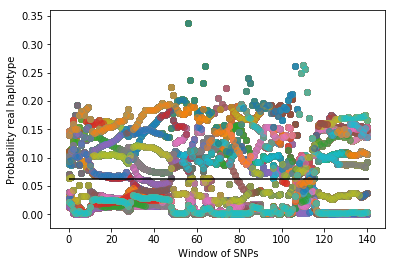

In [104]:
for i in range(0, Ydata_seg.shape[0], 10):
    Yproba = []
    categories = [np.argmax(data) for data in Ydata_seg[i]]
    for k in range(len(Ydata_seg[i])):
        cat = categories[k]
        proba=Ypred_seg[0][k]/sum(Ypred_seg[0][k])
        Yproba.append(proba[cat])
    plt.scatter(list(range(len(Ydata_seg[i]))),Yproba, alpha = 0.5)
plt.hlines(1/16,0,len(Ydata_seg[i]))
plt.xlabel("Window of SNPs")
plt.ylabel("Probability real haplotype")
plt.show()

## CNN + LSTM + quadruple-length (12035 SNPs)

### Define and train the model

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM, TimeDistributed, Bidirectional
from keras.layers import Conv1D, Conv2D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils, plot_model
import pickle

In [49]:
n = 16    # founders
p = 12035 # nb of SNPs
G = 20    # nb of generations
N = 100   # number recombining individuals in a generation after sampling
I = 100   # nb of itérations

**Import simulations** : genotypes and haplotypes, F = founders, d = descendants.

In [50]:
with open("Recombinations_haplotypes_test_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    haplo = pickle.load(handler)
    F_haplo = np.array(haplo[:n])
    d_haplo = np.array(haplo[n:])
display(F_haplo.shape,d_haplo.shape)
        
with open("Recombinations_genotypes_test_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    geno = pickle.load(handler)
    F_geno = np.array(geno[:n])
    d_geno = np.array(geno[n:])
    
with open("Linkage_p{}.pkl".format(p),"rb") as handler:
    linkage = pickle.load(handler)

display(F_geno.shape,d_geno.shape, linkage.shape)

(16, 1015)

(10000, 1015)

(16, 1015)

(10000, 1015)

(1015,)

In [51]:
xtrain = d_geno[:3*I*N//4]
ytrain = d_haplo[:3*I*N//4]
xtest = d_geno[3*I*N//4:]
ytest = d_haplo[3*I*N//4:]
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((7500, 1015), (7500, 1015), (2500, 1015), (2500, 1015))

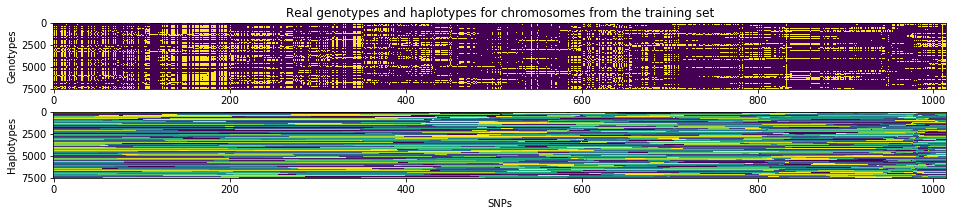

In [52]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,3))
ax1.imshow(xtrain, aspect = 0.01)
ax1.set(ylabel = "Genotypes", title = "Real genotypes and haplotypes for chromosomes from the training set")
ax2.imshow(ytrain, aspect = 0.01)
ax2.set(ylabel = "Haplotypes", xlabel = "SNPs")
plt.show()

**Input genotypes** : creating an "image" with the descendant x17 alterning with the 16 founders and the linkage.

In [53]:
def chromosome_alternate_inputs_5 (array, F_geno, linkage, n):
    A = np.zeros((array.shape[0],array.shape[1],3*n+1))
    for k in range(len(array)) :
        individual = array[k]
        a = individual[:, np.newaxis]
        for l in range(len(F_geno)) :
            a=np.concatenate([a,F_geno[l:l+1].T, linkage[:, np.newaxis], individual[:, np.newaxis]], axis = 1)
        A[k]=a
    return A

**Output haplotypes** in 2 SNPs-long segments.

In [54]:
def chromosome_segments_output (array):
    B = np.zeros((len(array),len(array[0])//2,16))
    for k in range(len(array)) :
        individual = array[k]
        B[k] = np.array([np_utils.to_categorical(segment[1]-1,16) for segment in np.reshape(individual[:len(individual)//2*2],(-1,2))])
    return B

In [ ]:
Xtrain = chromosome_alternate_inputs_5(xtrain, F_geno, linkage, n)
display(Xtrain.shape)
Ytrain = chromosome_segments_output(ytrain)
display(Ytrain.shape)
Xtest = chromosome_alternate_inputs_5(xtest, F_geno, linkage, n)
display(Xtest.shape)
Ytest = chromosome_segments_output(ytest)
display(Ytest.shape)

(7500, 1015, 49)

**Segment** all data in smaller more manageable inputs and outputs.

Given G recombination events (= generations because we assumed 1 recombination by generation), we can calculate the probability of having no recombination between 2 points with evenly distributed recombinations loci :

$$P = \Big(\frac{\text{total length - length}}{\text{total length}}\Big)^\text{number of generations} = \Big(\frac{p - L}{p}\Big)^G$$

So we can get the minimum required length L to have most of the information ($99\%$) :

$$P>1\% \implies \Big(\frac{p - L}{p}\Big)^G > 0.01 \implies p - L > p \times \sqrt[G]{0.01} \implies L < p(1 - \sqrt[G]{0.01})$$

In [ ]:
def length_segment (p, G, risk) :
    return int(p*(1-risk**(1/G)))

risk = 0.05
length_segment(p, G, risk)

In [ ]:
def random_segmentation_2 (A, B, p, G, risk) :
    l = length_segment(p, G, risk)
    assert p-4*l >= 0, p-4*l
    X = np.zeros((A.shape[0]*math.ceil(p/l),4*l,A.shape[2]))
    Y = np.zeros((B.shape[0]*math.ceil(p/l),2*l,B.shape[2]))
    for i in range(A.shape[0]):
        for j in range(math.ceil(p/l)):
            r = np.random.randint(0,p-4*l+1)
            X[i*math.ceil(p/l)+j] = A[i,r:r+4*l]
            Y[i*math.ceil(p/l)+j] = B[i,int(r/2):int(r/2)+2*l]
    return X,Y

In [ ]:
Xtrain_seg, Ytrain_seg = random_segmentation_2 (Xtrain, Ytrain, p, G, risk)
display(Xtrain_seg.shape, Ytrain_seg.shape)

Xtest_seg, Ytest_seg = random_segmentation_2 (Xtest, Ytest, p, G, risk)
display(Xtest_seg.shape, Ytest_seg.shape)

In [ ]:
im, ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(Xtrain[0].T, aspect = 2)
ax.set(xlabel = "SNPs", ylabel = "Individuals", title = "Training genotypes for 1 descendant x17 + 16 founders + linkage x17")
plt.show()

In [ ]:
im, ax = plt.subplots(1,2,figsize=(16,4))
for i in range(2):
    ax[i].imshow(Xtrain_seg[i].T, aspect = 2.7)
    ax[i].set(xlabel = "SNPs", ylabel = "Individuals", title = "Random input segment")
plt.show()

In [ ]:
im, ax = plt.subplots(1,2,figsize=(16,4))
for i in range(2):
    ax[i].imshow(Xtrain_seg[-i-1].T, aspect = 2.7)
    ax[i].set(xlabel = "SNPs", ylabel = "Individuals", title = "Random input segment")
plt.show()

In [ ]:
im, ax = plt.subplots(1,1,figsize=(16,6))
ax.imshow(Ytrain[0].T, aspect = 1, cmap = "Greys_r")
ax.set(xlabel = "SNPs", ylabel = "Individuals", title = "Expected prediction for the 16 founders")
plt.show()

In [ ]:
im, ax = plt.subplots(1,2,figsize=(16,3))
for i in range(2):
    ax[i].imshow(Ytrain_seg[i].T, aspect = 1.3, cmap = "Greys_r")
    ax[i].set(xlabel = "SNPs", ylabel = "Individuals", title = "Segmented expected prediction")
plt.show()

**Define LSTM** :

In [16]:
K.clear_session()

model_2 = Sequential()
model_2.add(Conv1D(49, kernel_size=2,
                 activation='relu',
                 input_shape=Xtest_seg.shape[1:], padding = 'same'))
model_2.add(Conv1D(30, kernel_size=2, activation='relu', padding='same'))
model_2.add(AveragePooling1D(pool_size=2,strides=2))
model_2.add(Dropout(0.25))
model_2.add(Conv1D(16, kernel_size=2, activation='relu', padding='same'))
model_2.add(Dropout(0.25))
model_2.add(TimeDistributed(Dense(16, activation='relu')))
model_2.add(Dropout(0.5))
model_2.add(TimeDistributed(Dense(16, activation='relu')))
model_2.add(Dropout(0.5))
model_2.add(Bidirectional(LSTM(8, return_sequences=True)))
model_2.add(TimeDistributed(Dense(Ytest_seg.shape[2], activation='softmax')))
model_2.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
filepath="Scalable2_model_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
print(model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 564, 49)           4851      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 564, 30)           2970      
_________________________________________________________________
average_pooling1d_1 (Average (None, 282, 30)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 282, 30)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 282, 16)           976       
_________________________________________________________________
dropout_2 (Dropout)          (None, 282, 16)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 282, 16)           272       
__________

In [17]:
plot_model(model_2, show_shapes=True, to_file='Models/Scalable2_model.png')

**Train LSTM** :

In [52]:
epochs=1
history_2 = model_2.fit(Xtrain_seg, Ytrain_seg,
          epochs=epochs,
          callbacks=callbacks_list,
          verbose=1,
          validation_data=(Xtest_seg, Ytest_seg))

Train on 60000 samples, validate on 20000 samples
Epoch 1/1
60000/60000 [==============================] - 2970s 49ms/step - loss: 0.2959 - acc: 0.0326 - val_loss: 0.8947 - val_acc: 0.0707

Epoch 00001: val_acc improved from -inf to 0.07071, saving model to Scalable2_model_weights-improvement-01-0.07.hdf5


In [13]:
with open('Scalable2_model_history.pkl', 'wb') as handler:
        pickle.dump(history_2.history, handler)

$\to$ Reached **32% accuracy after 22 epochs**.

### Load Check-Pointed model and make predictions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM, TimeDistributed, Bidirectional
from keras.layers import Conv1D, Conv2D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils, plot_model
import pickle

/Users/jeje/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
n = 16    # founders
p = 12035  # nb of SNPs
G = 20    # nb of generations
N = 100   # number recombining individuals in a generation after sampling
I = 10   # nb of itérations

In [3]:
with open("Recombinations_haplotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    haplo = pickle.load(handler)
    F_haplo_test = np.array(haplo[:n])
    d_haplo_test = np.array(haplo[n:])
display(F_haplo_test.shape,d_haplo_test.shape)
        
with open("Recombinations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    geno = pickle.load(handler)
    F_geno_test = np.array(geno[:n])
    d_geno_test = np.array(geno[n:])
    
with open("Linkage_p{}.pkl".format(p),"rb") as handler:
    linkage = pickle.load(handler)

display(F_geno_test.shape,d_geno_test.shape, linkage.shape)

(16, 12035)

(1000, 12035)

(16, 12035)

(1000, 12035)

(12035,)

In [4]:
def chromosome_alternate_inputs_5 (array, F_geno, linkage, n):
    A = np.zeros((array.shape[0],array.shape[1],3*n+1))
    for k in range(len(array)) :
        individual = array[k]
        a = individual[:, np.newaxis]
        for l in range(len(F_geno)) :
            a=np.concatenate([a,F_geno[l:l+1].T, linkage[:, np.newaxis], individual[:, np.newaxis]], axis = 1)
        A[k]=a
    return A

In [5]:
def chromosome_segments_output (array):
    B = np.zeros((len(array),len(array[0])//2,16))
    for k in range(len(array)) :
        individual = array[k]
        B[k] = np.array([np_utils.to_categorical(segment[1]-1,16) for segment in np.reshape(individual[:len(individual)//2*2],(-1,2))])
    return B

In [6]:
def length_segment (p, G, risk) :
    return int(p*(1-risk**(1/G)))

risk = 0.05
l = length_segment(p, G, risk)    # Number of informative SNPs from a given point
l

1674

In [7]:
def random_segmentation_2 (A, B, p, G, risk) :
    l = length_segment(p, G, risk)
    assert p-4*l >= 0, p-4*l
    X = np.zeros((A.shape[0]*math.ceil(p/l),4*l,A.shape[2]))
    Y = np.zeros((B.shape[0]*math.ceil(p/l),2*l,B.shape[2]))
    for i in range(A.shape[0]):
        for j in range(math.ceil(p/l)):
            r = np.random.randint(0,p-4*l+1)
            X[i*math.ceil(p/l)+j] = A[i,r:r+4*l]
            Y[i*math.ceil(p/l)+j] = B[i,int(r/2):int(r/2)+2*l]
    return X,Y

In [8]:
Xdata = chromosome_alternate_inputs_5(d_geno_test, F_geno_test, linkage, n)
display(Xdata.shape)
Ydata = chromosome_segments_output(d_haplo_test)
display(Ydata.shape)
Xdata_seg, Ydata_seg = random_segmentation_2 (Xdata, Ydata, p, G, risk)
display(Xdata_seg.shape, Ydata_seg.shape)

(1000, 12035, 49)

(1000, 6017, 16)

(8000, 6696, 49)

(8000, 3348, 16)

In [9]:
K.clear_session()

model_2 = Sequential()
model_2.add(Conv1D(49, kernel_size=2,
                 activation='relu',
                 input_shape=Xdata_seg.shape[1:], padding = 'same'))
model_2.add(Conv1D(30, kernel_size=2, activation='relu', padding='same'))
model_2.add(AveragePooling1D(pool_size=2,strides=2))
model_2.add(Dropout(0.25))
model_2.add(Conv1D(16, kernel_size=2, activation='relu', padding='same'))
model_2.add(Dropout(0.25))
model_2.add(TimeDistributed(Dense(16, activation='relu')))
model_2.add(Dropout(0.5))
model_2.add(TimeDistributed(Dense(16, activation='relu')))
model_2.add(Dropout(0.5))
model_2.add(Bidirectional(LSTM(8, return_sequences=True)))
model_2.add(TimeDistributed(Dense(Ydata_seg.shape[2], activation='softmax')))
model_2.load_weights("Models/Scalable2_model_weights/Scalable2_model_weights-improvement-22-0.32.hdf5")       # load weights
model_2.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
print(model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 6696, 49)          4851      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6696, 30)          2970      
_________________________________________________________________
average_pooling1d_1 (Average (None, 3348, 30)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3348, 30)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3348, 16)          976       
_________________________________________________________________
dropout_2 (Dropout)          (None, 3348, 16)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3348, 16)          272       
__________

In [10]:
Ypred_seg = model_2.predict(Xdata_seg)
display(Ypred_seg.shape)

(8000, 3348, 16)

In [11]:
model_2.evaluate(Xdata_seg, Ydata_seg)

8000/8000 [==============================] - 747s 93ms/step


[1.7958668537139892, 0.31115841513872144]

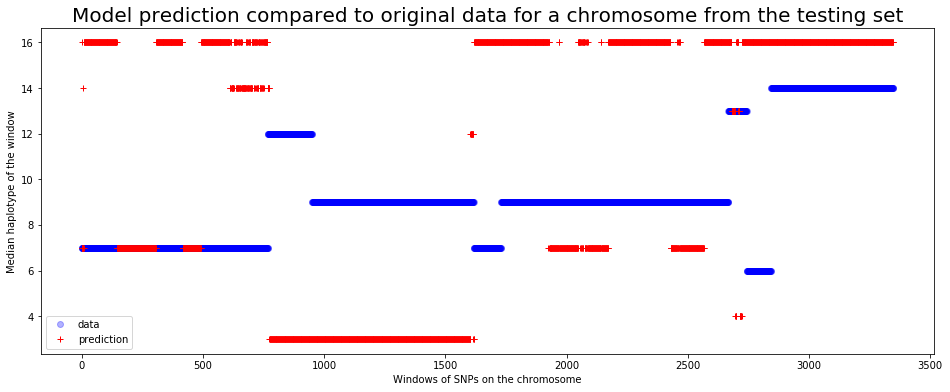

In [12]:
im, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot([np.argmax(data)+1 for data in Ydata_seg[0]], 'bo', label="data",alpha=0.3)
ax.plot([np.argmax(pred)+1 for pred in Ypred_seg[0]], 'r+', label="prediction")
ax.legend()
plt.xlabel("Windows of SNPs on the chromosome")
plt.ylabel("Median haplotype of the window")
plt.title("Model prediction compared to original data for a chromosome from the testing set",fontsize=20)
plt.show()

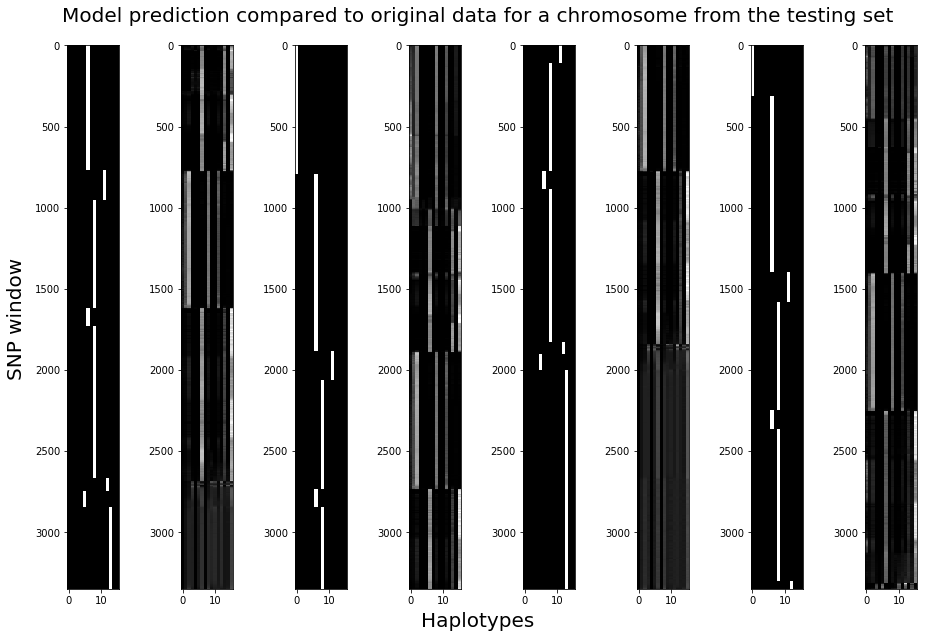

In [47]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(1,8,figsize=(16,10))
ax1.imshow(Ydata_seg[0],cmap="Greys_r", aspect = 0.05)
ax2.imshow(Ypred_seg[0],cmap="Greys_r", aspect = 0.05)
ax3.imshow(Ydata_seg[1],cmap="Greys_r", aspect = 0.05)
ax4.imshow(Ypred_seg[1],cmap="Greys_r", aspect = 0.05)
ax5.imshow(Ydata_seg[2],cmap="Greys_r", aspect = 0.05)
ax6.imshow(Ypred_seg[2],cmap="Greys_r", aspect = 0.05)
ax7.imshow(Ydata_seg[3],cmap="Greys_r", aspect = 0.05)
ax8.imshow(Ypred_seg[3],cmap="Greys_r", aspect = 0.05)
fig.text(0.5, 0.08, 'Haplotypes', ha='center', va='center',fontsize=20)
fig.text(0.1, 0.5, 'SNP window', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5, 0.92, 'Model prediction compared to original data for a chromosome from the testing set', ha='center', va='center',fontsize=20)
plt.show()

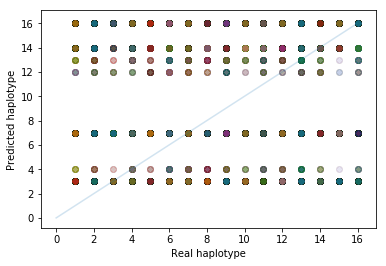

In [14]:
plt.plot([0,16],[0,16],alpha=0.2)
for i in range(0, Ydata_seg.shape[0], 50):
    plt.scatter([np.argmax(data)+1 for data in Ydata_seg[i]],[np.argmax(pred)+1 for pred in Ypred_seg[0]],alpha = 0.01)
plt.xlabel("Real haplotype")
plt.ylabel("Predicted haplotype")
plt.show()

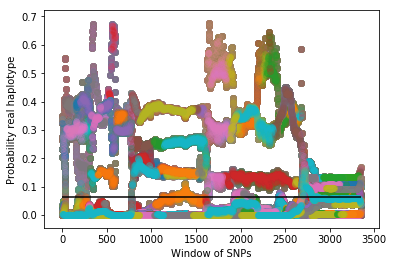

In [48]:
for i in range(0, Ydata_seg.shape[0], 10):
    Yproba = []
    categories = [np.argmax(data) for data in Ydata_seg[i]]
    for k in range(len(Ydata_seg[i])):
        cat = categories[k]
        proba=Ypred_seg[0][k]/sum(Ypred_seg[0][k])
        Yproba.append(proba[cat])
    plt.scatter(list(range(len(Ydata_seg[i]))),Yproba, alpha = 0.1)
plt.hlines(1/16,0,len(Ydata_seg[i]))
plt.xlabel("Window of SNPs")
plt.ylabel("Probability real haplotype")
plt.show()

## Idem + less parameters

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM, TimeDistributed, Bidirectional
from keras.layers import Conv1D, Conv2D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils, plot_model
import pickle

In [20]:
n = 16    # founders
p = 12035 # nb of SNPs
G = 20    # nb of generations
N = 100   # number recombining individuals in a generation after sampling
I = 10   # nb of itérations

**Import simulations** : genotypes and haplotypes, F = founders, d = descendants

In [21]:
with open("Recombinations_haplotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    haplo = pickle.load(handler)
    F_haplo = np.array(haplo[:n])
    d_haplo = np.array(haplo[n:])
display(F_haplo.shape,d_haplo.shape)
        
with open("Recombinations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    geno = pickle.load(handler)
    F_geno = np.array(geno[:n])
    d_geno = np.array(geno[n:])
    
with open("Linkage_p{}.pkl".format(p),"rb") as handler:
    linkage = pickle.load(handler)

display(F_geno.shape,d_geno.shape, linkage.shape)

(16, 12035)

(1000, 12035)

(16, 12035)

(1000, 12035)

(12035,)

In [22]:
xtrain = d_geno[:9*I*N//10]
ytrain = d_haplo[:9*I*N//10]
xtest = d_geno[9*I*N//10:]
ytest = d_haplo[9*I*N//10:]
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((900, 12035), (900, 12035), (100, 12035), (100, 12035))

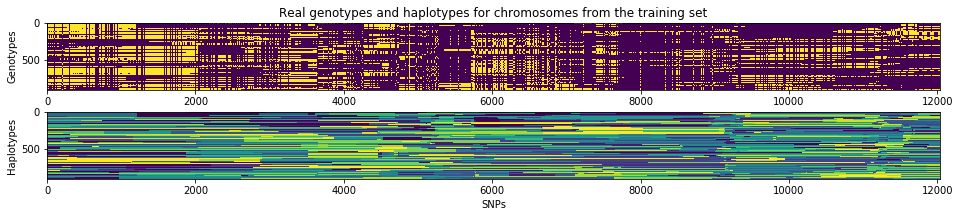

In [38]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,3))
ax1.imshow(xtrain, aspect = 1)
ax1.set(ylabel = "Genotypes", title = "Real genotypes and haplotypes for chromosomes from the training set")
ax2.imshow(ytrain, aspect = 1)
ax2.set(ylabel = "Haplotypes", xlabel = "SNPs")
plt.show()

**Input genotypes** : creating an "image" with the descendant x17 alterning with the 16 founders and the linkage.

In [24]:
def chromosome_alternate_inputs_5 (array, F_geno, linkage, n):
    A = np.zeros((array.shape[0],array.shape[1],3*n+1))
    for k in range(len(array)) :
        individual = array[k]
        a = individual[:, np.newaxis]
        for l in range(len(F_geno)) :
            a=np.concatenate([a,F_geno[l:l+1].T, linkage[:, np.newaxis], individual[:, np.newaxis]], axis = 1)
        A[k]=a
    return A

**Output haplotypes** in 2 SNPs-long segments.

In [25]:
def chromosome_segments_output (array):
    B = np.zeros((len(array),len(array[0])//2,16))
    for k in range(len(array)) :
        individual = array[k]
        B[k] = np.array([np_utils.to_categorical(segment[1]-1,16) for segment in np.reshape(individual[:len(individual)//2*2],(-1,2))])
    return B

In [26]:
Xtrain = chromosome_alternate_inputs_5(xtrain, F_geno, linkage, n)
display(Xtrain.shape)
Ytrain = chromosome_segments_output(ytrain)
display(Ytrain.shape)
Xtest = chromosome_alternate_inputs_5(xtest, F_geno, linkage, n)
display(Xtest.shape)
Ytest = chromosome_segments_output(ytest)
display(Ytest.shape)

(900, 12035, 49)

(900, 6017, 16)

(100, 12035, 49)

(100, 6017, 16)

**Segment** all data in smaller more manageable inputs and outputs.

Given G recombination events (= generations because we assumed 1 recombination by generation), we can calculate the probability of having no recombination between 2 points with evenly distributed recombinations loci :

$$P = \Big(\frac{\text{total length - length}}{\text{total length}}\Big)^\text{number of generations} = \Big(\frac{p - L}{p}\Big)^G$$

So we can get the minimum required length L to have most of the information ($99\%$) :

$$P>1\% \implies \Big(\frac{p - L}{p}\Big)^G > 0.01 \implies p - L > p \times \sqrt[G]{0.01} \implies L < p(1 - \sqrt[G]{0.01})$$

In [27]:
def length_segment (p, G, risk) :
    return int(p*(1-risk**(1/G)))

risk = 0.05
length_segment(p, G, risk)

1674

In [28]:
def random_segmentation_3 (A, B, p, G, risk) :
    l = length_segment(p, G, risk)
    assert p-4*l >= 0, p-4*l
    X = np.zeros((A.shape[0]*math.ceil(p/(4*l)),4*l,A.shape[2]))
    Y = np.zeros((B.shape[0]*math.ceil(p/(4*l)),2*l,B.shape[2]))
    for i in range(A.shape[0]):
        for j in range(math.ceil(p/(4*l))):
            r = np.random.randint(0,p-4*l+1)
            X[i*math.ceil(p/(4*l))+j] = A[i,r:r+4*l]
            Y[i*math.ceil(p/(4*l))+j] = B[i,int(r/2):int(r/2)+2*l]
    return X,Y

In [29]:
Xtrain_seg, Ytrain_seg = random_segmentation_3 (Xtrain, Ytrain, p, G, risk)
display(Xtrain_seg.shape, Ytrain_seg.shape)

Xtest_seg, Ytest_seg = random_segmentation_3 (Xtest, Ytest, p, G, risk)
display(Xtest_seg.shape, Ytest_seg.shape)

(1800, 6696, 49)

(1800, 3348, 16)

(200, 6696, 49)

(200, 3348, 16)

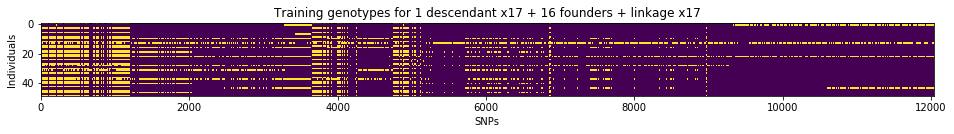

In [39]:
im, ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(Xtrain[0].T, aspect = 20)
ax.set(xlabel = "SNPs", ylabel = "Individuals", title = "Training genotypes for 1 descendant x17 + 16 founders + linkage x17")
plt.show()

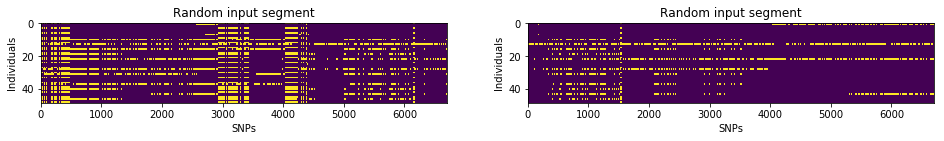

In [40]:
im, ax = plt.subplots(1,2,figsize=(16,4))
for i in range(2):
    ax[i].imshow(Xtrain_seg[i].T, aspect = 27)
    ax[i].set(xlabel = "SNPs", ylabel = "Individuals", title = "Random input segment")
plt.show()

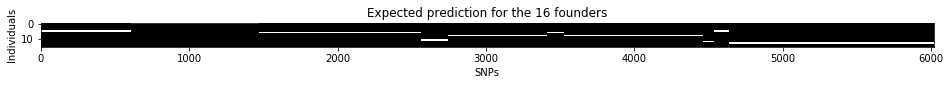

In [42]:
im, ax = plt.subplots(1,1,figsize=(16,6))
ax.imshow(Ytrain[0].T, aspect = 10, cmap = "Greys_r")
ax.set(xlabel = "SNPs", ylabel = "Individuals", title = "Expected prediction for the 16 founders")
plt.show()

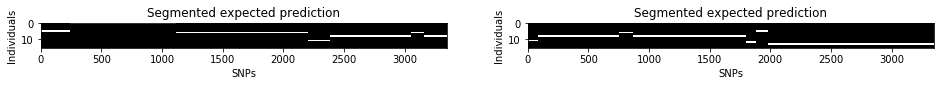

In [43]:
im, ax = plt.subplots(1,2,figsize=(16,3))
for i in range(2):
    ax[i].imshow(Ytrain_seg[i].T, aspect = 13, cmap = "Greys_r")
    ax[i].set(xlabel = "SNPs", ylabel = "Individuals", title = "Segmented expected prediction")
plt.show()

**Define LSTM** :

In [35]:
K.clear_session()

model_3 = Sequential()
model_3.add(Conv1D(49, kernel_size=2,
                 activation='relu',
                 input_shape=Xtest_seg.shape[1:], padding = 'same'))
model_3.add(Conv1D(16, kernel_size=2, activation='relu', padding='same'))
model_3.add(AveragePooling1D(pool_size=2,strides=2))
model_3.add(Dropout(0.25))
model_3.add(TimeDistributed(Dense(16, activation='relu')))
model_3.add(Dropout(0.5))
model_3.add(TimeDistributed(Dense(16, activation='relu')))
model_3.add(Dropout(0.5))
model_3.add(Bidirectional(LSTM(8, return_sequences=True)))
model_3.add(TimeDistributed(Dense(Ytest_seg.shape[2], activation='softmax')))
model_3.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
filepath="Scalable3_model_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
print(model_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 6696, 49)          4851      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6696, 16)          1584      
_________________________________________________________________
average_pooling1d_1 (Average (None, 3348, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3348, 16)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3348, 16)          272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 3348, 16)          0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 3348, 16)          272       
__________

In [36]:
plot_model(model_3, show_shapes=True, to_file='Models/Scalable3_model.png')

**Train LSTM** :

In [ ]:
epochs=1
history_3 = model_3.fit(Xtrain_seg, Ytrain_seg,
          epochs=epochs,
          callbacks=callbacks_list,
          verbose=1,
          validation_data=(Xtest_seg, Ytest_seg))

Train on 1800 samples, validate on 200 samples
Epoch 1/1
 320/1800 [====>.........................] - ETA: 13:02 - loss: 2.7577 - acc: 0.0790

In [13]:
with open('Scalable3_model_history.pkl', 'wb') as handler:
        pickle.dump(history_3.history, handler)

$\to$ Reached **34% accuracy after 76 epochs /100**

# Combine segments

## Linear segmentation of the input

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM, TimeDistributed, Bidirectional
from keras.layers import Conv1D, Conv2D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils, plot_model
import pickle

Using TensorFlow backend.


In [2]:
n = 16    # founders
p = 12035 # nb of SNPs
G = 20    # nb of generations
N = 100   # number recombining individuals in a generation after sampling
I = 10    # nb of itérations

In [3]:
with open("Recombinations_haplotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    haplo = pickle.load(handler)
    F_haplo_test = np.array(haplo[:n])
    d_haplo_test = np.array(haplo[n:])
display(F_haplo_test.shape,d_haplo_test.shape)
        
with open("Recombinations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    geno = pickle.load(handler)
    F_geno_test = np.array(geno[:n])
    d_geno_test = np.array(geno[n:])
    
with open("Linkage_p{}.pkl".format(p),"rb") as handler:
    linkage = pickle.load(handler)

display(F_geno_test.shape,d_geno_test.shape, linkage.shape)

(16, 12035)

(1000, 12035)

(16, 12035)

(1000, 12035)

(12035,)

In [4]:
def chromosome_alternate_inputs_5 (array, F_geno, linkage, n):
    A = np.zeros((array.shape[0],array.shape[1],3*n+1))
    for k in range(len(array)) :
        individual = array[k]
        a = individual[:, np.newaxis]
        for l in range(len(F_geno)) :
            a=np.concatenate([a,F_geno[l:l+1].T, linkage[:, np.newaxis], individual[:, np.newaxis]], axis = 1)
        A[k]=a
    return A

In [5]:
def chromosome_segments_output (array):
    B = np.zeros((len(array),len(array[0])//2,16))
    for k in range(len(array)) :
        individual = array[k]
        B[k] = np.array([np_utils.to_categorical(segment[1]-1,16) for segment in np.reshape(individual[:len(individual)//2*2],(-1,2))])
    return B

In [6]:
def length_segment (p, G, risk) :
    return int(p*(1-risk**(1/G)))

risk = 0.05
l = length_segment(p, G, risk)
l

1674

In [7]:
def linear_segmentation (A, B, p, l) :
    #assert p-4*l >= 0, p-4*l
    d = math.ceil((p-6*l)/(2*l))+2      # Required number of segments : 2 at the extremities + at least (p-6*l)/(2*l)
    X = np.zeros((A.shape[0]*d,4*l,A.shape[2]))
    Y = np.zeros((B.shape[0]*d,2*l,B.shape[2]))
    for i in range(A.shape[0]):
        X[i*d] = A[i,:4*l]              # Starting segment
        Y[i*d] = B[i,:2*l]
        for j in range(1,d-1):
            X[i*d+j] = A[i,(1+2*j)*l:(5+2*j)*l]
            Y[i*d+j] = B[i,int((1+2*j)*l/2):int((5+2*j)*l/2)]
        X[(i+1)*d-1] = A[i,-4*l:]       # Ending segment
        Y[(i+1)*d-1] = B[i,-2*l:]
    return X,Y

In [8]:
Xdata = chromosome_alternate_inputs_5(d_geno_test, F_geno_test, linkage, n)
display(Xdata.shape)
Ydata = chromosome_segments_output(d_haplo_test)
display(Ydata.shape)

(1000, 12035, 49)

(1000, 6017, 16)

In [9]:
Xdata_seg, Ydata_seg = linear_segmentation (Xdata, Ydata, p, l)
display(Xdata_seg.shape, Ydata_seg.shape)

(3000, 6696, 49)

(3000, 3348, 16)

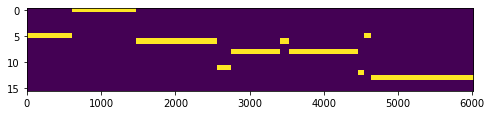

In [10]:
im, ax = plt.subplots(1,1, figsize = (8,4))
ax.imshow(Ydata[0].T, aspect = 70)
plt.show()

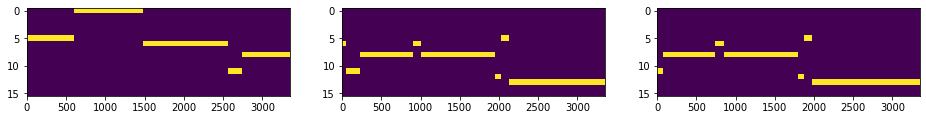

In [11]:
im, ax = plt.subplots(1,3, figsize = (16,4))
for i in range(3):
    ax[i].imshow(Ydata_seg[i].T, aspect = 70)
plt.show()

## Scalable 2

### Predict with the model

In [61]:
K.clear_session()

model_2 = Sequential()
model_2.add(Conv1D(49, kernel_size=2,
                 activation='relu',
                 input_shape=Xdata_seg.shape[1:], padding = 'same'))
model_2.add(Conv1D(30, kernel_size=2, activation='relu', padding='same'))
model_2.add(AveragePooling1D(pool_size=2,strides=2))
model_2.add(Dropout(0.25))
model_2.add(Conv1D(16, kernel_size=2, activation='relu', padding='same'))
model_2.add(Dropout(0.25))
model_2.add(TimeDistributed(Dense(16, activation='relu')))
model_2.add(Dropout(0.5))
model_2.add(TimeDistributed(Dense(16, activation='relu')))
model_2.add(Dropout(0.5))
model_2.add(Bidirectional(LSTM(8, return_sequences=True)))
model_2.add(TimeDistributed(Dense(Ydata_seg.shape[2], activation='softmax')))
model_2.load_weights("Models/Scalable2_model_weights/Scalable2_model_weights-improvement-22-0.32.hdf5")       # load weights
model_2.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
print(model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 6696, 49)          4851      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6696, 30)          2970      
_________________________________________________________________
average_pooling1d_1 (Average (None, 3348, 30)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3348, 30)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3348, 16)          976       
_________________________________________________________________
dropout_2 (Dropout)          (None, 3348, 16)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3348, 16)          272       
__________

In [63]:
Ypred_seg = model_2.predict(Xdata_seg)
display(Ypred_seg.shape)

(3000, 3348, 16)

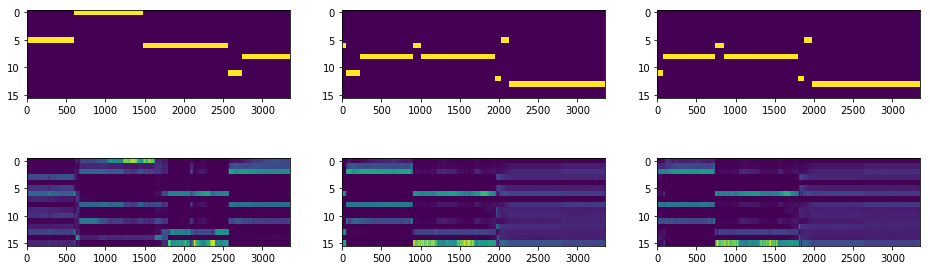

In [67]:
im, ax = plt.subplots(2,3, figsize = (16,5))
for i in range(3):
    ax[0,i].imshow(Ydata_seg[i].T, aspect = 70)
    ax[1,i].imshow(Ypred_seg[i].T, aspect = 70)
plt.show()

In [152]:
Ypred_seg_max = np.array([[np_utils.to_categorical(np.argmax(A),16) for A in B] for B in Ypred_seg])
Ypred_seg_max.shape

(3000, 3348, 16)

In [153]:
from sklearn.metrics import accuracy_score
acc_seg = np.mean([accuracy_score(Ydata_seg[i], Ypred_seg_max[i]) for i in range(len(Ydata_seg))])
print(acc_seg)

0.27766129032258063


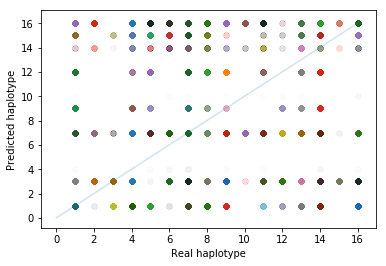

In [161]:
plt.plot([0,16],[0,16],alpha=0.2)
for i in range(0, Ydata_seg.shape[0], 200):
    plt.scatter([np.argmax(data)+1 for data in Ydata_seg[i]],[np.argmax(pred)+1 for pred in Ypred_seg[0]],alpha = 0.005)
plt.xlabel("Real haplotype")
plt.ylabel("Predicted haplotype")
plt.show()

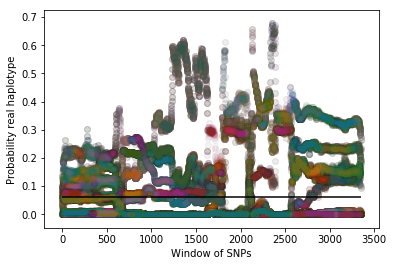

In [162]:
for i in range(0, Ydata_seg.shape[0], 10):
    Yproba = []
    categories = [np.argmax(data) for data in Ydata_seg[i]]
    for k in range(len(Ydata_seg[i])):
        cat = categories[k]
        proba=Ypred_seg[0][k]/sum(Ypred_seg[0][k])
        Yproba.append(proba[cat])
    plt.scatter(list(range(len(Ydata_seg[i]))),Yproba, alpha = 0.01)
plt.hlines(1/16,0,len(Ydata_seg[i]))
plt.xlabel("Window of SNPs")
plt.ylabel("Probability real haplotype")
plt.show()

In [ ]:
for i in range(0, Ydata_seg.shape[0], 10):
    Yproba = []
    categories = [np.argmax(data) for data in Ydata_seg[i]]
    for k in range(len(Ydata_seg[i])):
        cat = categories[k]
        proba=Ypred_seg[0][k]/sum(Ypred_seg[0][k])
        Yproba.append(proba[cat])
    plt.scatter(list(range(len(Ydata_seg[i]))),Yproba, alpha = 0.01)
plt.hlines(1/16,0,len(Ydata_seg[i]))
plt.xlabel("Window of SNPs")
plt.ylabel("Probability real haplotype")
plt.show()

$\to$ **28% accuracy before recombination**

### Combine the predicted segments

In [107]:
def combine_segments (Ypred_seg, Ydata, p, l):
    Y = np.zeros(Ydata.shape)
    d = math.ceil((p-6*l)/(2*l))+2      # Required number of segments : 2 at the extremities + at least (p-6*l)/(2*l)
    for i in range(Y.shape[0]):
        Y[i] = np.concatenate((Ypred_seg[i*d,:3*l//2], np.reshape(np.array([Ypred_seg[i*d+j,l//2:3*l//2] for j in range(1,d-1)]), (l,n)), Ypred_seg[(i+1)*d-1,-(p-3*l-2*d*l)//2+1:]),axis = 0)
    return Y

In [108]:
Ypred = combine_segments (Ypred_seg, Ydata, p, l)
Ypred.shape

(1000, 6017, 16)

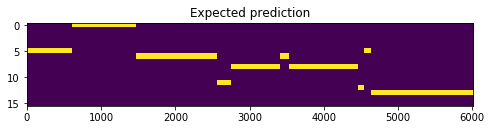

In [165]:
im, ax = plt.subplots(1,1, figsize = (8,4))
ax.imshow(Ydata[0].T, aspect = 70)
ax.set (title="Expected prediction")
plt.show()

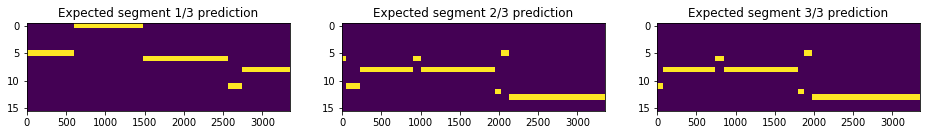

In [167]:
im, ax = plt.subplots(1,3, figsize = (16,4))
for i in range(3):
    ax[i].imshow(Ydata_seg[i].T, aspect = 70)
    ax[i].set (title="Expected segment {}/{} prediction".format(i+1,d))
plt.show()

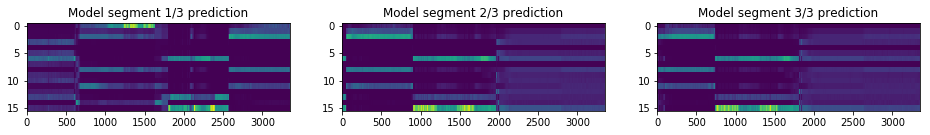

In [168]:
im, ax = plt.subplots(1,3, figsize = (16,4))
for i in range(3):
    ax[i].imshow(Ypred_seg[i].T, aspect = 70)
    ax[i].set (title="Model segment {}/{} prediction".format(i+1,d))
plt.show()

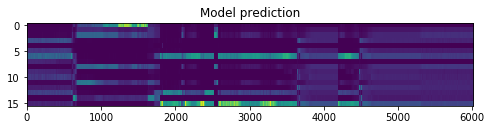

In [169]:
im, ax = plt.subplots(1,1, figsize = (8,4))
ax.imshow(Ypred[0].T, aspect = 70)
ax.set (title="Model prediction")
plt.show()

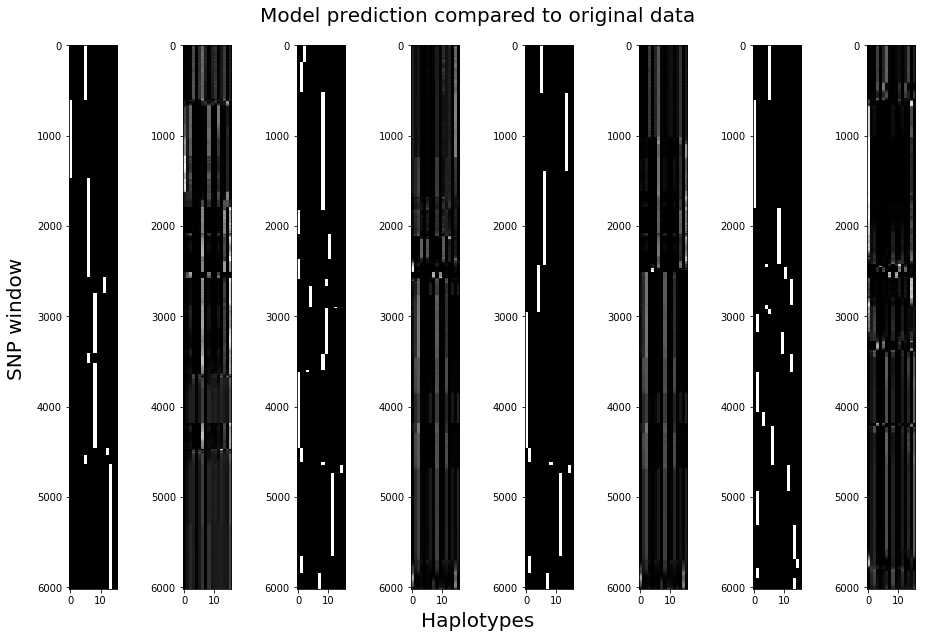

In [117]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(1,8,figsize=(16,10))
ax1.imshow(Ydata[0],cmap="Greys_r", aspect = 0.03)
ax2.imshow(Ypred[0],cmap="Greys_r", aspect = 0.03)
ax3.imshow(Ydata[1],cmap="Greys_r", aspect = 0.03)
ax4.imshow(Ypred[1],cmap="Greys_r", aspect = 0.03)
ax5.imshow(Ydata[2],cmap="Greys_r", aspect = 0.03)
ax6.imshow(Ypred[2],cmap="Greys_r", aspect = 0.03)
ax7.imshow(Ydata[3],cmap="Greys_r", aspect = 0.03)
ax8.imshow(Ypred[3],cmap="Greys_r", aspect = 0.03)
fig.text(0.5, 0.08, 'Haplotypes', ha='center', va='center',fontsize=20)
fig.text(0.1, 0.5, 'SNP window', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5, 0.92, 'Model prediction compared to original data', ha='center', va='center',fontsize=20)
plt.show()

In [132]:
acc = keras.metrics.categorical_accuracy(Ydata, Ypred_max)

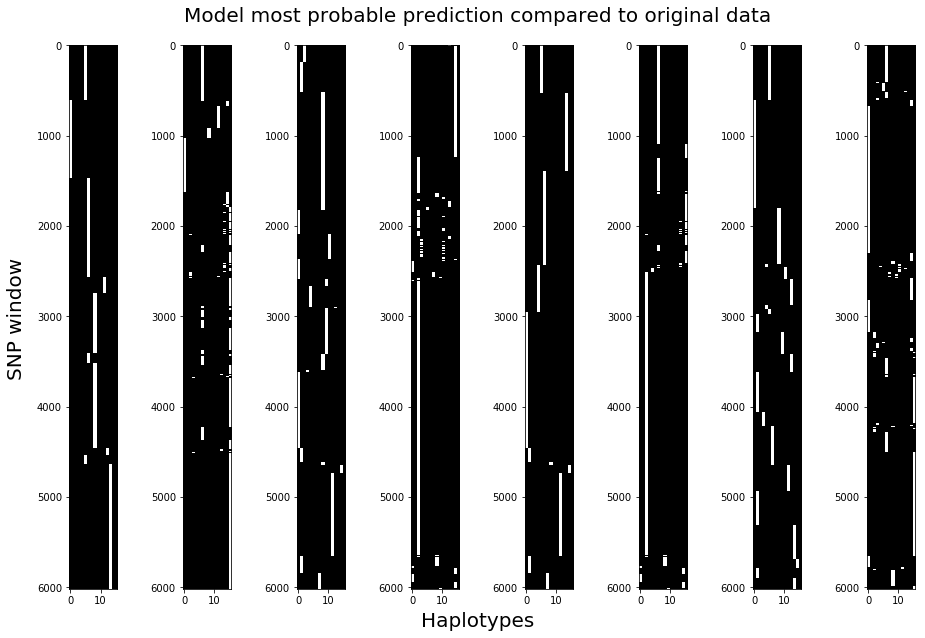

In [127]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(1,8,figsize=(16,10))
ax1.imshow(Ydata[0],cmap="Greys_r", aspect = 0.03)
ax2.imshow(Ypred_max[0],cmap="Greys_r", aspect = 0.03)
ax3.imshow(Ydata[1],cmap="Greys_r", aspect = 0.03)
ax4.imshow(Ypred_max[1],cmap="Greys_r", aspect = 0.03)
ax5.imshow(Ydata[2],cmap="Greys_r", aspect = 0.03)
ax6.imshow(Ypred_max[2],cmap="Greys_r", aspect = 0.03)
ax7.imshow(Ydata[3],cmap="Greys_r", aspect = 0.03)
ax8.imshow(Ypred_max[3],cmap="Greys_r", aspect = 0.03)
fig.text(0.5, 0.08, 'Haplotypes', ha='center', va='center',fontsize=20)
fig.text(0.1, 0.5, 'SNP window', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5, 0.92, 'Model most probable prediction compared to original data', ha='center', va='center',fontsize=20)
plt.show()

In [126]:
Ypred_max = np.array([[np_utils.to_categorical(np.argmax(A),16) for A in B] for B in Ypred])
Ypred_max.shape

(1000, 6017, 16)

In [149]:
acc = np.mean([accuracy_score(Ydata[i], Ypred_max[i]) for i in range(len(Ydata))])
print(acc)

0.22588947980721288


$\to$ **23% accuracy after combination** $\to$ Should increase instead of decreasing !

## Scalable 3

### Predict with the model

In [10]:
K.clear_session()

model_3 = Sequential()
model_3.add(Conv1D(49, kernel_size=2,
                 activation='relu',
                 input_shape=Xdata_seg.shape[1:], padding = 'same'))
model_3.add(Conv1D(16, kernel_size=2, activation='relu', padding='same'))
model_3.add(AveragePooling1D(pool_size=2,strides=2))
model_3.add(Dropout(0.25))
model_3.add(TimeDistributed(Dense(16, activation='relu')))
model_3.add(Dropout(0.5))
model_3.add(TimeDistributed(Dense(16, activation='relu')))
model_3.add(Dropout(0.5))
model_3.add(Bidirectional(LSTM(8, return_sequences=True)))
model_3.add(TimeDistributed(Dense(Ydata_seg.shape[2], activation='softmax')))
model_3.load_weights("Models/Scalable3_model_weights/Scalable3_model_weights-improvement-86-0.34.hdf5")       # load weights
model_3.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
print(model_3.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 6696, 49)          4851      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6696, 16)          1584      
_________________________________________________________________
average_pooling1d_1 (Average (None, 3348, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3348, 16)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3348, 16)          272       
_________________________________________________________________
dropout_2 (Dropout)  

In [11]:
Ypred_seg = model_3.predict(Xdata_seg)
display(Ypred_seg.shape)

(3000, 3348, 16)

In [ ]:
im, ax = plt.subplots(2,3, figsize = (16,5))
for i in range(3):
    ax[0,i].imshow(Ydata_seg[i].T, aspect = 70)
    ax[1,i].imshow(Ypred_seg[i].T, aspect = 70)
plt.show()

In [12]:
Ypred_seg_max = np.array([[np_utils.to_categorical(np.argmax(A),16) for A in B] for B in Ypred_seg])
Ypred_seg_max.shape

(3000, 3348, 16)

In [15]:
from sklearn.metrics import accuracy_score
acc_seg = np.mean([accuracy_score(Ydata_seg[i], Ypred_seg_max[i]) for i in range(len(Ydata_seg))])
print(acc_seg)

0.3370735762644365


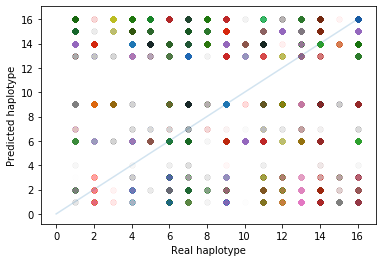

In [16]:
plt.plot([0,16],[0,16],alpha=0.2)
for i in range(0, Ydata_seg.shape[0], 200):
    plt.scatter([np.argmax(data)+1 for data in Ydata_seg[i]],[np.argmax(pred)+1 for pred in Ypred_seg[0]],alpha = 0.005)
plt.xlabel("Real haplotype")
plt.ylabel("Predicted haplotype")
plt.show()

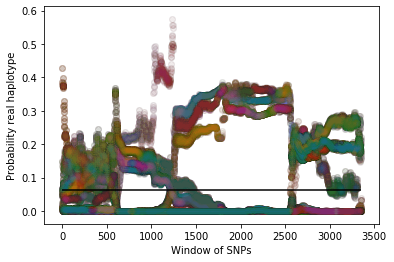

In [17]:
for i in range(0, Ydata_seg.shape[0], 10):
    Yproba = []
    categories = [np.argmax(data) for data in Ydata_seg[i]]
    for k in range(len(Ydata_seg[i])):
        cat = categories[k]
        proba=Ypred_seg[0][k]/sum(Ypred_seg[0][k])
        Yproba.append(proba[cat])
    plt.scatter(list(range(len(Ydata_seg[i]))),Yproba, alpha = 0.01)
plt.hlines(1/16,0,len(Ydata_seg[i]))
plt.xlabel("Window of SNPs")
plt.ylabel("Probability real haplotype")
plt.show()

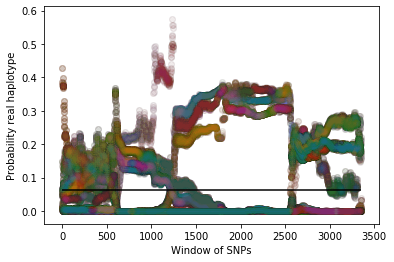

In [18]:
for i in range(0, Ydata_seg.shape[0], 10):
    Yproba = []
    categories = [np.argmax(data) for data in Ydata_seg[i]]
    for k in range(len(Ydata_seg[i])):
        cat = categories[k]
        proba=Ypred_seg[0][k]/sum(Ypred_seg[0][k])
        Yproba.append(proba[cat])
    plt.scatter(list(range(len(Ydata_seg[i]))),Yproba, alpha = 0.01)
plt.hlines(1/16,0,len(Ydata_seg[i]))
plt.xlabel("Window of SNPs")
plt.ylabel("Probability real haplotype")
plt.show()

### Combine the predicted segments

In [24]:
def combine_segments (Ypred_seg, Ydata, p, l, d):
    Y = np.zeros(Ydata.shape)
    for i in range(Y.shape[0]):
        Y[i] = np.concatenate((Ypred_seg[i*d,:3*l//2], np.reshape(np.array([Ypred_seg[i*d+j,l//2:3*l//2] for j in range(1,d-1)]), (l,n)), Ypred_seg[(i+1)*d-1,-(p-3*l-2*d*l)//2+1:]),axis = 0)
    return Y

In [25]:
d = math.ceil((p-6*l)/(2*l))+2      # Required number of segments : 2 at the extremities + at least (p-6*l)/(2*l)
Ypred = combine_segments (Ypred_seg, Ydata, p, l, d)
Ypred.shape

(1000, 6017, 16)

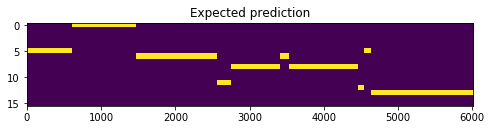

In [26]:
im, ax = plt.subplots(1,1, figsize = (8,4))
ax.imshow(Ydata[0].T, aspect = 70)
ax.set (title="Expected prediction")
plt.show()

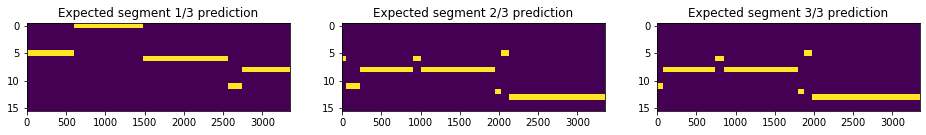

In [27]:
im, ax = plt.subplots(1,3, figsize = (16,4))
for i in range(3):
    ax[i].imshow(Ydata_seg[i].T, aspect = 70)
    ax[i].set (title="Expected segment {}/{} prediction".format(i+1,d))
plt.show()

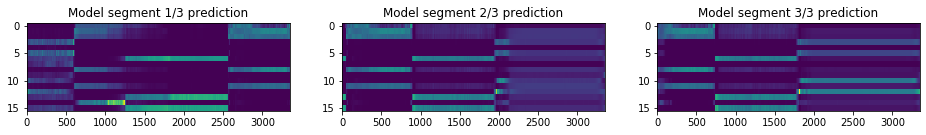

In [28]:
im, ax = plt.subplots(1,3, figsize = (16,4))
for i in range(3):
    ax[i].imshow(Ypred_seg[i].T, aspect = 70)
    ax[i].set (title="Model segment {}/{} prediction".format(i+1,d))
plt.show()

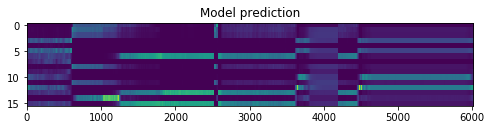

In [29]:
im, ax = plt.subplots(1,1, figsize = (8,4))
ax.imshow(Ypred[0].T, aspect = 70)
ax.set (title="Model prediction")
plt.show()

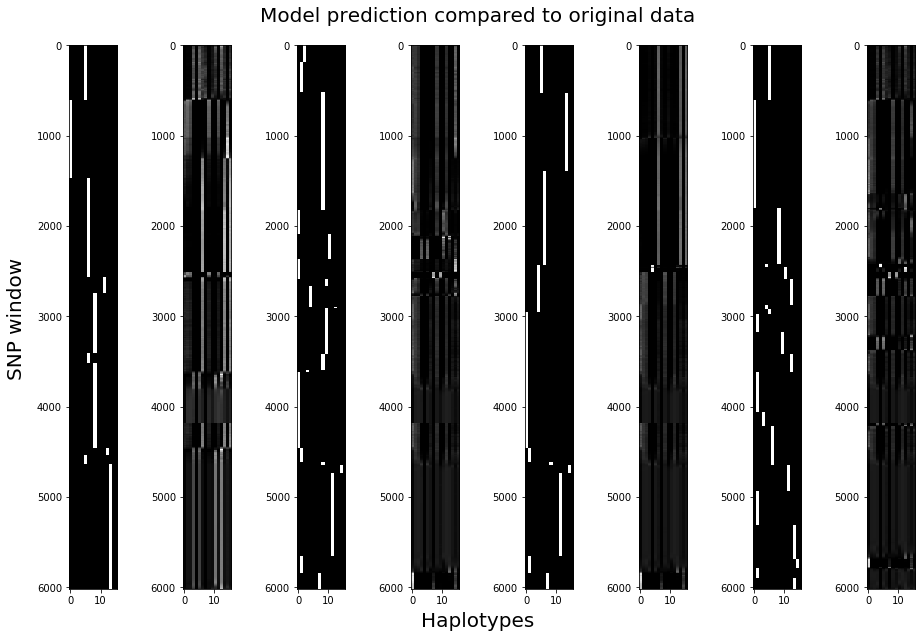

In [30]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(1,8,figsize=(16,10))
ax1.imshow(Ydata[0],cmap="Greys_r", aspect = 0.03)
ax2.imshow(Ypred[0],cmap="Greys_r", aspect = 0.03)
ax3.imshow(Ydata[1],cmap="Greys_r", aspect = 0.03)
ax4.imshow(Ypred[1],cmap="Greys_r", aspect = 0.03)
ax5.imshow(Ydata[2],cmap="Greys_r", aspect = 0.03)
ax6.imshow(Ypred[2],cmap="Greys_r", aspect = 0.03)
ax7.imshow(Ydata[3],cmap="Greys_r", aspect = 0.03)
ax8.imshow(Ypred[3],cmap="Greys_r", aspect = 0.03)
fig.text(0.5, 0.08, 'Haplotypes', ha='center', va='center',fontsize=20)
fig.text(0.1, 0.5, 'SNP window', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5, 0.92, 'Model prediction compared to original data', ha='center', va='center',fontsize=20)
plt.show()

In [ ]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(1,8,figsize=(16,10))
ax1.imshow(Ydata[0],cmap="Greys_r", aspect = 0.03)
ax2.imshow(Ypred_max[0],cmap="Greys_r", aspect = 0.03)
ax3.imshow(Ydata[1],cmap="Greys_r", aspect = 0.03)
ax4.imshow(Ypred_max[1],cmap="Greys_r", aspect = 0.03)
ax5.imshow(Ydata[2],cmap="Greys_r", aspect = 0.03)
ax6.imshow(Ypred_max[2],cmap="Greys_r", aspect = 0.03)
ax7.imshow(Ydata[3],cmap="Greys_r", aspect = 0.03)
ax8.imshow(Ypred_max[3],cmap="Greys_r", aspect = 0.03)
fig.text(0.5, 0.08, 'Haplotypes', ha='center', va='center',fontsize=20)
fig.text(0.1, 0.5, 'SNP window', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5, 0.92, 'Model most probable prediction compared to original data', ha='center', va='center',fontsize=20)
plt.show()

In [33]:
Ypred_max = np.array([[np_utils.to_categorical(np.argmax(A),16) for A in B] for B in Ypred])
Ypred_max.shape

(1000, 6017, 16)

In [35]:
acc = np.mean([accuracy_score(Ydata[i], Ypred_max[i]) for i in range(len(Ydata))])
print(acc)

0.2750161209905268
